In [2]:
from __future__ import absolute_import
from __future__ import division
from __future__ import print_function

from keras.layers import Lambda, Input, Dense
from keras.models import Model
from keras.datasets import mnist
from keras.losses import mse, binary_crossentropy
from keras.utils import plot_model
from keras import backend as K

import numpy as np
import matplotlib.pyplot as plt
import argparse
import os


# reparameterization trick
# instead of sampling from Q(z|X), sample eps = N(0,I)
# z = z_mean + sqrt(var)*eps
def sampling(args):
    """Reparameterization trick by sampling fr an isotropic unit Gaussian.
    # Arguments:
        args (tensor): mean and log of variance of Q(z|X)
    # Returns:
        z (tensor): sampled latent vector
    """

    z_mean, z_log_var = args
    batch = K.shape(z_mean)[0]
    dim = K.int_shape(z_mean)[1]
    # by default, random_normal has mean=0 and std=1.0
    epsilon = K.random_normal(shape=(batch, dim))
    thre = K.random_uniform(shape=(batch,1))
    return z_mean + K.exp(0.5 * z_log_var) * epsilon


def plot_results(models,
                 data,
                 batch_size=128,
                 model_name="vae_mnist"):
    """Plots labels and MNIST digits as function of 2-dim latent vector
    # Arguments:
        models (tuple): encoder and decoder models
        data (tuple): test data and label
        batch_size (int): prediction batch size
        model_name (string): which model is using this function
    """

    encoder, decoder = models
    x_test, y_test = data
    os.makedirs(model_name, exist_ok=True)

    filename = os.path.join(model_name, "vae_mean.png")
    # display a 2D plot of the digit classes in the latent space
    z_mean, _, _ = encoder.predict(x_test,
                                   batch_size=batch_size)
    plt.figure(figsize=(12, 10))
    plt.scatter(z_mean[:, 0], z_mean[:, 1], c=y_test)
    plt.colorbar()
    plt.xlabel("z[0]")
    plt.ylabel("z[1]")
    plt.savefig(filename)
    plt.show()

    filename = os.path.join(model_name, "digits_over_latent.png")
    # display a 30x30 2D manifold of digits
    n = 30
    digit_size = 28
    figure = np.zeros((digit_size * n, digit_size * n))
    # linearly spaced coordinates corresponding to the 2D plot
    # of digit classes in the latent space
    grid_x = np.linspace(-4, 4, n)
    grid_y = np.linspace(-4, 4, n)[::-1]

    for i, yi in enumerate(grid_y):
        for j, xi in enumerate(grid_x):
            z_sample = np.array([[xi, yi]])
            x_decoded = decoder.predict(z_sample)
            digit = x_decoded[0].reshape(digit_size, digit_size)
            figure[i * digit_size: (i + 1) * digit_size,
                   j * digit_size: (j + 1) * digit_size] = digit

    plt.figure(figsize=(10, 10))
    start_range = digit_size // 2
    end_range = n * digit_size + start_range + 1
    pixel_range = np.arange(start_range, end_range, digit_size)
    sample_range_x = np.round(grid_x, 1)
    sample_range_y = np.round(grid_y, 1)
    plt.xticks(pixel_range, sample_range_x)
    plt.yticks(pixel_range, sample_range_y)
    plt.xlabel("z[0]")
    plt.ylabel("z[1]")
    plt.imshow(figure, cmap='Greys_r')
    plt.savefig(filename)
    plt.show()

In [3]:
# MNIST dataset
(x_train, y_train), (x_test, y_test) = mnist.load_data()

image_size = x_train.shape[1]
original_dim = image_size * image_size
x_train = np.reshape(x_train, [-1, original_dim])
x_test = np.reshape(x_test, [-1, original_dim])
x_train = x_train.astype('float32') / 255
x_test = x_test.astype('float32') / 255

idx_train = (y_train == 0) |(y_train == 5) | (y_train == 7) | (np.random.rand(y_train.shape[0]) < 0.05)
x_train = x_train[idx_train,:]
y_train = y_train[idx_train]
idx_test = (y_test == 0) |(y_test == 5) | (y_test == 7) | (np.random.rand(y_test.shape[0]) < 0.05)
x_test = x_test[idx_test,:]
y_test = y_test[idx_test]

# network parameters
input_shape = (original_dim, )
intermediate_dim = 512
batch_size = 256
latent_dim = 3
cat_dim = 1
epochs = 150

# VAE model = encoder + decoder
# build encoder model
inputs = Input(shape=input_shape, name='encoder_input')
x = Dense(intermediate_dim, activation='relu', name='encoder_intermediate')(inputs)

# add 3 means as additional parameters
dummy = Input(shape=(1,), name='dummy')
mu1 = Dense(latent_dim, name='mu1',use_bias=False)(dummy)
mu2 = Dense(latent_dim, name='mu2',use_bias=False)(dummy)
mu3 = Dense(latent_dim, name='mu3',use_bias=False)(dummy)

# prior categorical distribution
pi = Dense(3, activation='softmax', name='pi')(dummy)

# posterior categorical distribution
c = Dense(3, activation='softmax', name='c')(x)

# outlier/non-outlier classification (Posterior Beta)
#inter_outlier = Dense(128, activation='relu', name='inter_outlier')(x)
c_outlier = Dense(2, activation='softmax', name='c_outlier')(x)

# q(z|x)
z_mean = Dense(latent_dim, name='z_mean')(x)
z_log_var = Dense(latent_dim, name='z_log_var')(x)

# use reparameterization trick to push the sampling out as input
z = Lambda(sampling, output_shape=(latent_dim,), name='z')([z_mean, z_log_var])

# instantiate encoder model
encoder = Model([inputs,dummy], [z_mean, z_log_var, z, mu1, mu2, mu3, c, c_outlier, pi], name='encoder')
encoder.summary()

# build decoder model
latent_inputs = Input(shape=(latent_dim,), name='z_sampling')
x = Dense(intermediate_dim, activation='relu')(latent_inputs)
outputs = Dense(original_dim, activation='sigmoid')(x)

# instantiate decoder model
decoder = Model(latent_inputs, outputs, name='decoder')
decoder.summary()
#plot_model(decoder, to_file='vae_mlp_decoder.png', show_shapes=True)

# instantiate VAE model
outputs = decoder(encoder([inputs,dummy])[2])
vae = Model([inputs,dummy], outputs, name='vae_mlp')
vae.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
encoder_input (InputLayer)      (None, 784)          0                                            
__________________________________________________________________________________________________
encoder_intermediate (Dense)    (None, 512)          401920      encoder_input[0][0]              
__________________________________________________________________________________________________
z_mean (Dense)                  (None, 3)            1539        encoder_intermediate[0][0]       
__________________________________________________________________________________________________
z_log_var (Dense)               (None, 3)            1539        encoder_intermediate[0][0]       
__________________________________________________________________________________________________
dummy (Inp

In [4]:
models = (encoder, decoder)
data = (x_test, y_test)
dummy_train = np.ones((y_train.shape[0],1))
dummy_test  = np.ones((y_test.shape[0],1))

# weight for outlier Beta prior
# portion of outlier class
Lambda = 100
Alpha = 0.075

# stick-breaking reconstruction of categorical distribution
c0 = K.tf.multiply(c[:,0],c_outlier[:,0])
c1 = K.tf.multiply(c[:,1],c_outlier[:,0])
c2 = K.tf.multiply(c[:,2],c_outlier[:,0])
c3 = c_outlier[:,1]

# reconstruction loss
reconstruction_loss = mse(inputs, outputs)
reconstruction_loss = K.tf.multiply(reconstruction_loss, c0 + c1 + c2)
reconstruction_loss *= original_dim

# kl-divergence between q(z|x) and p(z|c)
kl_loss_1 = 1 + z_log_var - K.square(z_mean-mu1) - K.exp(z_log_var)
kl_loss_1 = K.tf.multiply(K.sum(kl_loss_1, axis=-1) , c0)
kl_loss_2 = 1 + z_log_var - K.square(z_mean-mu2) - K.exp(z_log_var)
kl_loss_2 = K.tf.multiply(K.sum(kl_loss_2, axis=-1) , c1)
kl_loss_3 = 1 + z_log_var - K.square(z_mean-mu3) - K.exp(z_log_var)
kl_loss_3 = K.tf.multiply(K.sum(kl_loss_3, axis=-1) , c2)
kl_loss_1 *= -0.5
kl_loss_2 *= -0.5
kl_loss_3 *= -0.5

# kl-divergence between q(c|x) and p(c) (not including outlier class)
mc1 = K.mean(c[:,0])
mc2 = K.mean(c[:,1])
mc3 = K.mean(c[:,2])
mpi1 = K.mean(pi[:,0])
mpi2 = K.mean(pi[:,1])
mpi3 = K.mean(pi[:,2])
kl_cat = (mc1 * K.log(mc1)- mc1 * K.log(mpi1)+
          mc2 * K.log(mc2)- mc2 * K.log(mpi2)+
          mc3 * K.log(mc3)- mc3 * K.log(mpi3))

# kl-divergence between Beta prior and Beta posterior (outlier class)
mco1 = K.mean(c_outlier[:,0])
mco2 = K.mean(c_outlier[:,1])
mpo1 = 1-Alpha
mpo2 = Alpha
kl_cat_outlier = (mco1 * K.log(mco1)- mco1 * np.log(mpo1)+
                  mco2 * K.log(mco2)- mco2 * np.log(mpo2))
          
# Dir prior  Dir(3, 3, 3)
dir_prior =  -2*K.log(pi[:,0])-2*K.log(pi[:,1])-2*K.log(pi[:,2])

# total loss
vae_loss = K.mean(reconstruction_loss+
                  kl_loss_1+kl_loss_2+kl_loss_3+
                  dir_prior+kl_cat+Lambda*kl_cat_outlier)

vae.add_loss(vae_loss)
vae.compile(optimizer='adam')
vae.summary()

#vae.load_weights('vae_mlp_mnist.h5')
vae.fit([x_train,dummy_train],
        epochs=epochs,
        batch_size=batch_size,
        validation_data=([x_test,dummy_test], None))
vae.save_weights('vae_mlp_mnist.h5')


__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
encoder_input (InputLayer)      (None, 784)          0                                            
__________________________________________________________________________________________________
dummy (InputLayer)              (None, 1)            0                                            
__________________________________________________________________________________________________
encoder (Model)                 [(None, 3), (None, 3 407578      encoder_input[0][0]              
                                                                 dummy[0][0]                      
__________________________________________________________________________________________________
decoder (Model)                 (None, 784)          404240      encoder[1][2]                    
Total para

Epoch 63/150
19813/19813 [==============================] - 3s 128us/step - loss: 32.5900 - val_loss: 32.7719
Epoch 64/150
19813/19813 [==============================] - 3s 128us/step - loss: 32.5636 - val_loss: 32.7424
Epoch 65/150
19813/19813 [==============================] - 3s 130us/step - loss: 32.5385 - val_loss: 32.7452
Epoch 66/150
19813/19813 [==============================] - 3s 131us/step - loss: 32.5065 - val_loss: 32.8353
Epoch 67/150
19813/19813 [==============================] - 3s 131us/step - loss: 32.5515 - val_loss: 32.7785
Epoch 68/150
19813/19813 [==============================] - 3s 129us/step - loss: 32.5119 - val_loss: 32.9711
Epoch 69/150
19813/19813 [==============================] - 3s 129us/step - loss: 32.5947 - val_loss: 32.7207
Epoch 70/150
19813/19813 [==============================] - 3s 129us/step - loss: 32.5101 - val_loss: 32.9995
Epoch 71/150
19813/19813 [==============================] - 3s 129us/step - loss: 32.4568 - val_loss: 32.7345
Epoch 72/1

19813/19813 [==============================] - 3s 137us/step - loss: 31.7097 - val_loss: 32.2473
Epoch 138/150
19813/19813 [==============================] - 2s 124us/step - loss: 31.6709 - val_loss: 32.1880
Epoch 139/150
19813/19813 [==============================] - 2s 121us/step - loss: 31.7292 - val_loss: 32.2595
Epoch 140/150
19813/19813 [==============================] - 2s 122us/step - loss: 31.7762 - val_loss: 32.1028
Epoch 141/150
19813/19813 [==============================] - 3s 137us/step - loss: 31.7535 - val_loss: 32.2527
Epoch 142/150
19813/19813 [==============================] - 2s 125us/step - loss: 31.6637 - val_loss: 32.1011
Epoch 143/150
19813/19813 [==============================] - 2s 116us/step - loss: 31.6761 - val_loss: 32.0927
Epoch 144/150
19813/19813 [==============================] - 3s 126us/step - loss: 31.7096 - val_loss: 32.0770
Epoch 145/150
19813/19813 [==============================] - 3s 128us/step - loss: 31.6433 - val_loss: 32.0760
Epoch 146/150
1

<IPython.core.display.Javascript object>


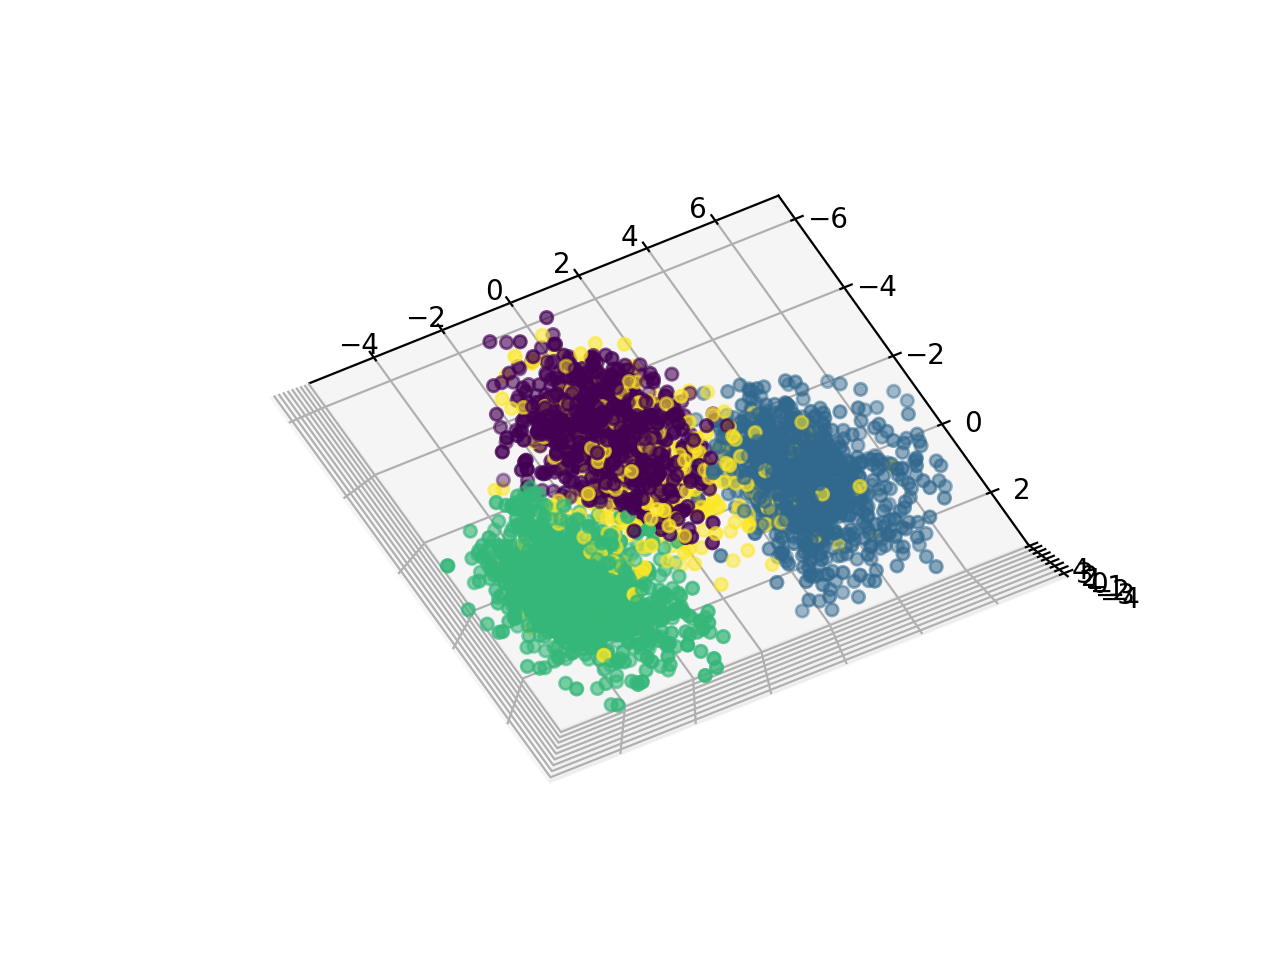

(-6.039537644386291, 7.996005749702453, -6.47606475353241, 3.3411527395248415)

In [6]:
[z_mean, z_log_var, z, mu1, mu2, mu3, c_1, c_2, pi] = encoder.predict([x_test,dummy_test],batch_size=batch_size)

# estimate label
c0 = c_1[:,0] * c_2[:,0]
c1 = c_1[:,1] * c_2[:,0]
c2 = c_1[:,2] * c_2[:,0]
c3 = c_2[:,1]

color = np.ones(y_test.shape[0])*3
for i in range(0, y_test.shape[0]):
    if (c0[i] > c1[i]) and (c0[i] > c2[i]) and (c0[i] > c3[i]):
        color[i] = 0
    if (c1[i] > c0[i]) and (c1[i] > c2[i]) and (c1[i] > c3[i]):
        color[i] = 1
    if (c2[i] > c0[i]) and (c2[i] > c1[i]) and (c2[i] > c3[i]):
        color[i] = 2
        
# plot using computed or ground-truth label
from mpl_toolkits.mplot3d import Axes3D
%matplotlib notebook
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
color_gt = y_test.copy()
color_gt[(color_gt!=0) & (color_gt!=5) & (color_gt!=7)] = 9
color_gt[(color_gt==0)]=0;
color_gt[(color_gt==5)]=1;
color_gt[(color_gt==7)]=2;
color_gt[(color_gt==9)]=3;


ax.scatter(z_mean[:, 0], z_mean[:, 1],z_mean[:,2], c=color)
ax.axis('equal')

In [ ]:
pi